In [1]:
import pandas as pd

from src.eda_utils import (
    general_exploration,
    plot_correlations,
    analyze_time_series_for_machine,
    analyze_trend_spikes,
    plot_stl_decomposition,
    plot_sensor_distributions,
    plot_acf_and_pacf,
    analyze_maintenance_by_component,
    analyze_weekend_maintenance,
    analyze_time_features
)

from src.data.data_utils import load_data, merge_multiple_dataframes
from src.transformations.features import (
    add_time_since_last_event_features,
    encode_machine_model,
    encode_time,
)

In [2]:
dfs = load_data()
df = merge_multiple_dataframes(dfs)

In [3]:
general_exploration(dfs)


--- PdM_maint ---
Shape: (3286, 3)
Column types:
datetime     datetime64[ns]
machineID             int64
comp                 object
dtype: object
First 3 rows:
             datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 06:00:00          1  comp4
2 2014-07-31 06:00:00          1  comp3
Null values (%):
datetime     0.0
machineID    0.0
comp         0.0
dtype: float64
Duplicate rows: 0
Datetime range: 2014-06-01 06:00:00 to 2016-01-01 06:00:00
Unique machines: 100

--- PdM_machines ---
Shape: (100, 3)
Column types:
machineID     int64
model        object
age           int64
dtype: object
First 3 rows:
   machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
Null values (%):
machineID    0.0
model        0.0
age          0.0
dtype: float64
Duplicate rows: 0
Unique machines: 100

--- PdM_failures ---
Shape: (761, 3)
Column types:
datetime     datetime64[ns]
machineID             int64
failure              ob

The dataset comprises five primary tables capturing telemetry, maintenance, failures, errors, and machine metadata, each of which was thoroughly examined. The telemetry data (PdM_telemetry) is the largest, containing over 876,000 hourly records for 100 machines in 2015, with no missing values, duplicates, or missing timestamps. Sensor readings such as voltage, rotation, pressure, and vibration show consistent distributions with realistic variability. The maintenance dataset (PdM_maint) includes 3,286 component replacements from 2014 to 2016, also covering all 100 machines without missing or duplicated records. The failure log (PdM_failures), a subset of maintenance data, registers 761 component failures in 2015, most frequently involving components comp2 and comp1, and spans 98 out of 100 machines. The error log (PdM_errors) contains nearly 4,000 non-critical events, consistently recorded across all machines throughout 2015. Finally, the machine metadata (PdM_machines) provides static information on model type and machine age, with each machine uniquely represented. Across all datasets, the data appears clean and complete, making it suitable for further modeling and analysis.

In [4]:
# Feature engineering
df = add_time_since_last_event_features(df)
df = encode_time(df)
df = encode_machine_model(df)

# Convert to datetime & set multi-index
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index(["machineID", "datetime"], inplace=True,drop=False)


In [5]:
df[df['machineID'] == 1].head()

datetime  machineID        volt  \
machineID datetime                                                         
1         2015-01-01 06:00:00 2015-01-01 06:00:00          1  176.217853   
          2015-01-01 07:00:00 2015-01-01 07:00:00          1  162.879223   
          2015-01-01 08:00:00 2015-01-01 08:00:00          1  170.989902   
          2015-01-01 09:00:00 2015-01-01 09:00:00          1  162.462833   
          2015-01-01 10:00:00 2015-01-01 10:00:00          1  157.610021   

                                   rotate    pressure  vibration errorID  \
machineID datetime                                                         
1         2015-01-01 06:00:00  418.504078  113.077935  45.087686    none   
          2015-01-01 07:00:00  402.747490   95.460525  43.413973    none   
          2015-01-01 08:00:00  527.349825   75.237905  34.178847    none   
          2015-01-01 09:00:00  346.149335  109.248561  41.122144    none   
          2015-01-01 10:00:00  435.376873  111.886648  25.990511    none   

                              failure  maint_comp1  maint_comp2  ...  \
machineID datetime                                               ...   
1         2015-01-01 06:00:00    none          0.0          0.0  ...   
          2015-01-01 07:00:00    none          0.0          0.0  ...   
          2015-01-01 08:00:00    none          0.0          0.0  ...   
          2015-01-01 09:00:00    none          0.0          0.0  ...   
          2015-01-01 10:00:00    none          0.0          0.0  ...   

                               time_since_last_failure_flag_known  \
machineID datetime                                                  
1         2015-01-01 06:00:00                                   0   
          2015-01-01 07:00:00                                   0   
          2015-01-01 08:00:00                                   0   
          2015-01-01 09:00:00                                   0   
          2015-01-01 10:00:00                                   0   

                               time_since_last_failure_flag  hour_sin  \
machineID datetime                                                      
1         2015-01-01 06:00:00                       10000.0  1.000000   
          2015-01-01 07:00:00                       10000.0  0.965926   
          2015-01-01 08:00:00                       10000.0  0.866025   
          2015-01-01 09:00:00                       10000.0  0.707107   
          2015-01-01 10:00:00                       10000.0  0.500000   

                                   hour_cos  dayofweek_sin  dayofweek_cos  \
machineID datetime                                                          
1         2015-01-01 06:00:00  6.123234e-17       0.433884      -0.900969   
          2015-01-01 07:00:00 -2.588190e-01       0.433884      -0.900969   
          2015-01-01 08:00:00 -5.000000e-01       0.433884      -0.900969   
          2015-01-01 09:00:00 -7.071068e-01       0.433884      -0.900969   
          2015-01-01 10:00:00 -8.660254e-01       0.433884      -0.900969   

                               model_1  model_2  model_3  model_4  
machineID datetime                                                 
1         2015-01-01 06:00:00      0.0      0.0      1.0      0.0  
          2015-01-01 07:00:00      0.0      0.0      1.0      0.0  
          2015-01-01 08:00:00      0.0      0.0      1.0      0.0  
          2015-01-01 09:00:00      0.0      0.0      1.0      0.0  
          2015-01-01 10:00:00      0.0      0.0      1.0      0.0  

[5 rows x 59 columns]

In [6]:
print(df.columns)

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'errorID', 'failure', 'maint_comp1', 'maint_comp2', 'maint_comp3',
       'maint_comp4', 'failure_comp1', 'failure_comp2', 'failure_comp3',
       'failure_comp4', 'code_error1', 'code_error2', 'code_error3',
       'code_error4', 'code_error5', 'age', 'failure_flag',
       'time_since_last_maint_comp1_known', 'time_since_last_maint_comp1',
       'time_since_last_maint_comp2_known', 'time_since_last_maint_comp2',
       'time_since_last_maint_comp3_known', 'time_since_last_maint_comp3',
       'time_since_last_maint_comp4_known', 'time_since_last_maint_comp4',
       'time_since_last_failure_comp1_known', 'time_since_last_failure_comp1',
       'time_since_last_failure_comp2_known', 'time_since_last_failure_comp2',
       'time_since_last_failure_comp3_known', 'time_since_last_failure_comp3',
       'time_since_last_failure_comp4_known', 'time_since_last_failure_comp4',
       'time_since_last_code_erro

To get the dataset ready for modeling, I added several features that help capture patterns over time. One key step was calculating how many hours had passed since the last time certain events occurred, like a component failing, maintenance being done, or specific error codes showing up for each machine. For each of these, I also created a "known" column to mark whether we actually had previous data to calculate that time, and I filled in missing values with a large number (10,000) to signal that the history was unknown. This large number was accompanied by a boolean mask. Moreover, I encoded time features like the hour of the day and day of the week using sine and cosine transformations to reflect their natural cycles. Lastly, I took the machine model column, pulled out the number in it, and used one-hot encoding to turn it into separate binary columns for each model. These transformations help the model better understand time-related behaviors and differences between machines.

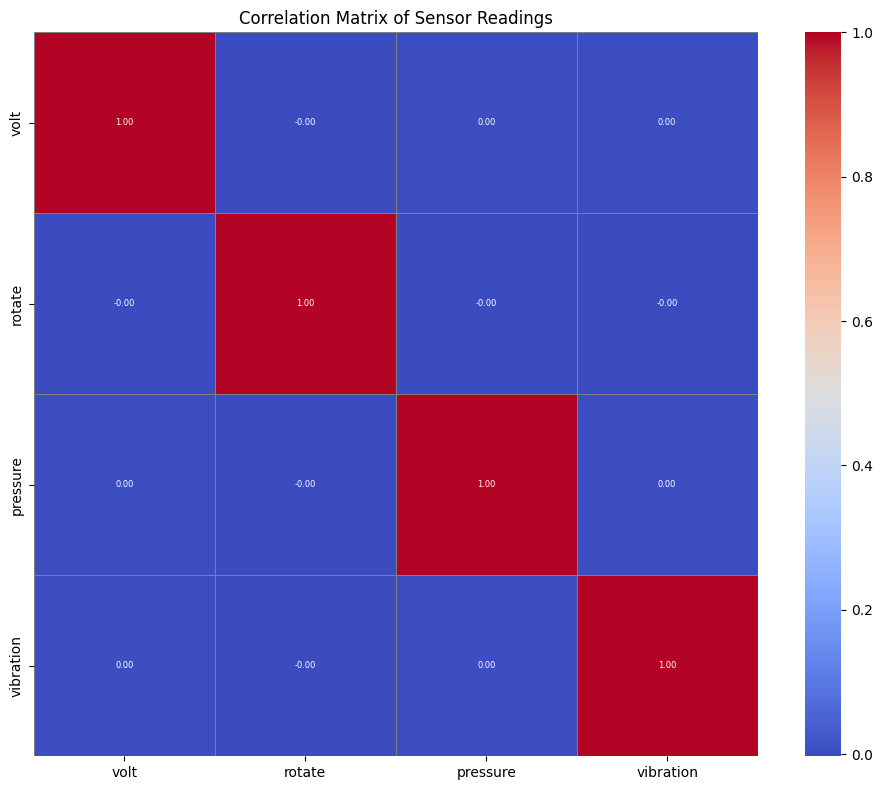

In [7]:
sensor_cols = ["volt", "rotate", "pressure", "vibration"]
plot_correlations(df, sensor_cols)


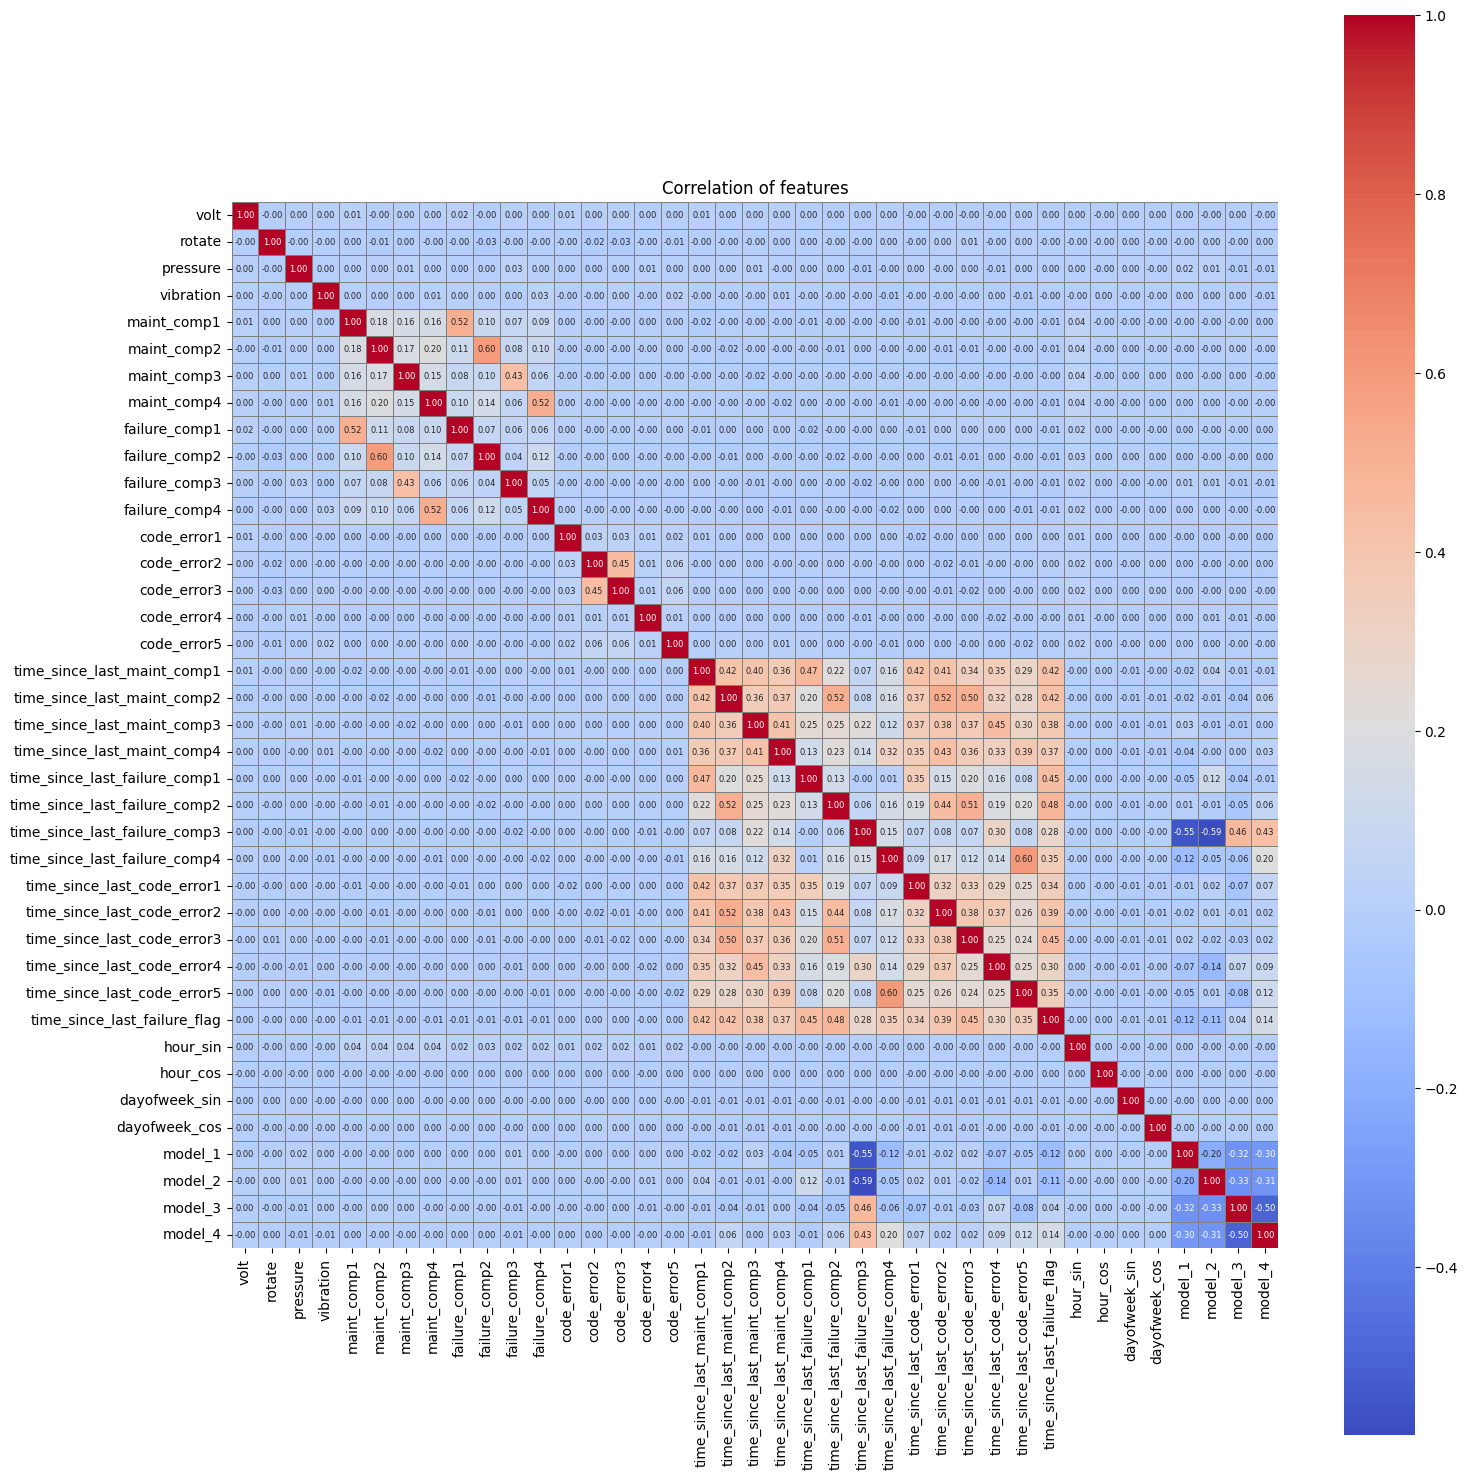

In [8]:
float_cols = df.select_dtypes(include="float").columns
plot_correlations(df, float_cols, 'Correlation of features')

The correlation matrix reveals various important relationships across sensor readings, event tracking features, and machine identifiers. Core sensor values like volt, rotate, pressure, and vibration show weak correlations with each other, indicating they represent largely independent physical aspects of the machines’ operation. These low interdependencies suggest that any anomalies in these sensors may signal different failure mechanisms or behaviors, making them valuable for multidimensional diagnostics.

One of the more insightful patterns appears in the engineered time-based features. There is a strong positive correlation between the “time since last failure” and “time since last code error” across components. This suggests that longer periods without code errors are generally accompanied by longer periods without failures, reflecting a consistent operational stability when the system is running smoothly. Similarly, there is also a positive correlation between “time since last failure” and “time since last maintenance”. This is intuitive: if maintenance has been performed recently, failures tend to be less likely, and conversely, the longer a machine goes without maintenance, the more probable a failure becomes. This relationship reinforces the idea that preventive maintenance plays a crucial role in system reliability.

Another important and more nuanced observation is the negative correlation between model_3 and time_since_last_failure_comp3. This implies that for machines of type model 3, failures in component 3 happen more frequently—since the time since the last failure tends to be lower. This could indicate that model 3 has either a structural or design vulnerability in that specific component, or that it's used in conditions that place more stress on component 3. Identifying such model-specific patterns is essential for targeted reliability engineering and proactive component replacement.

In contrast, cyclical time features like hour_sin, hour_cos, dayofweek_sin, and dayofweek_cos exhibit low correlations with most operational and failure-related features. This suggests that failure and maintenance events are not strongly tied to specific times of day or days of the week—at least within the resolution of the current data. Lastly, one-hot encoded model identifiers (model_1 to model_4) show low correlations overall, with a few weak associations that, as with model_3, may hint at subtle differences in reliability or usage patterns across machine types.

In summary, the correlation matrix not only highlights independent signals across sensor readings but also uncovers key dependencies between failure occurrence, code errors, and maintenance timing. These insights are valuable for both predictive maintenance strategies and understanding the operational characteristics of different machine mod

## Stationarity analysis

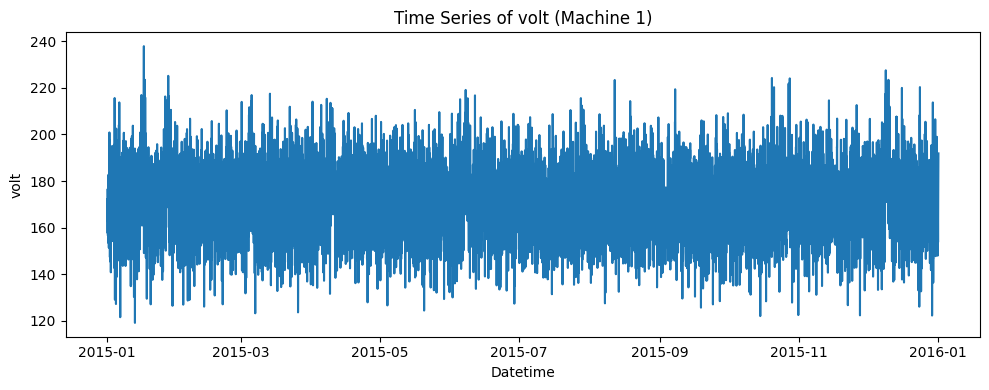

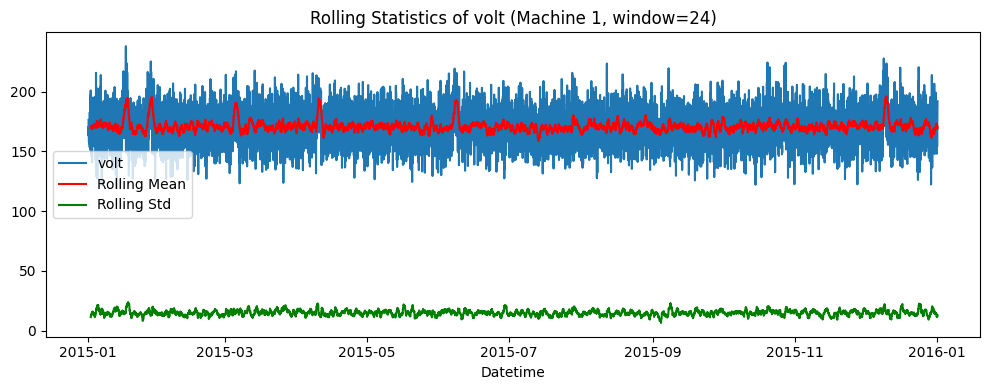

ADF Test for volt:
  Test Statistic: -14.0138
  p-value: 0.0000
----------------------------------------


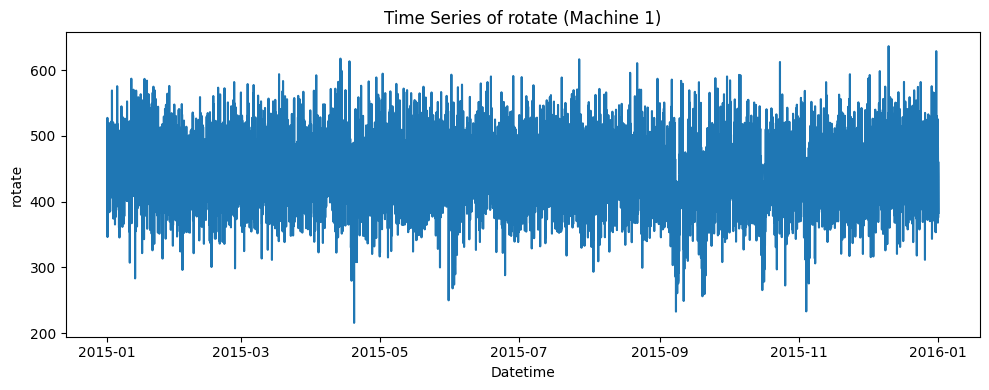

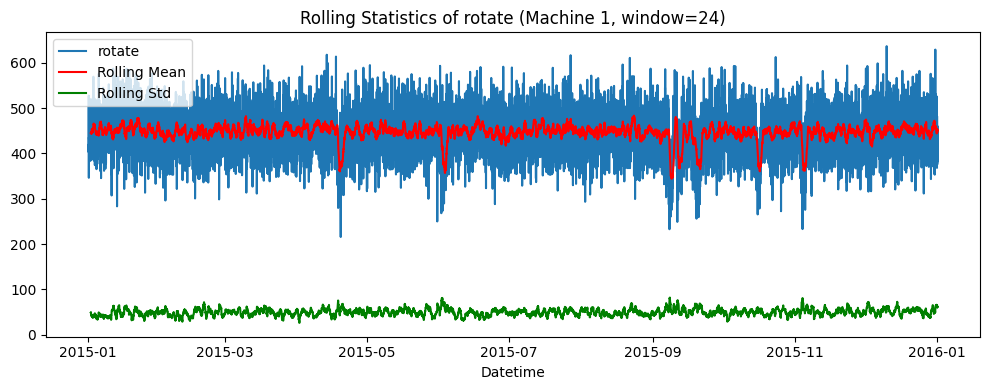

ADF Test for rotate:
  Test Statistic: -12.2708
  p-value: 0.0000
----------------------------------------


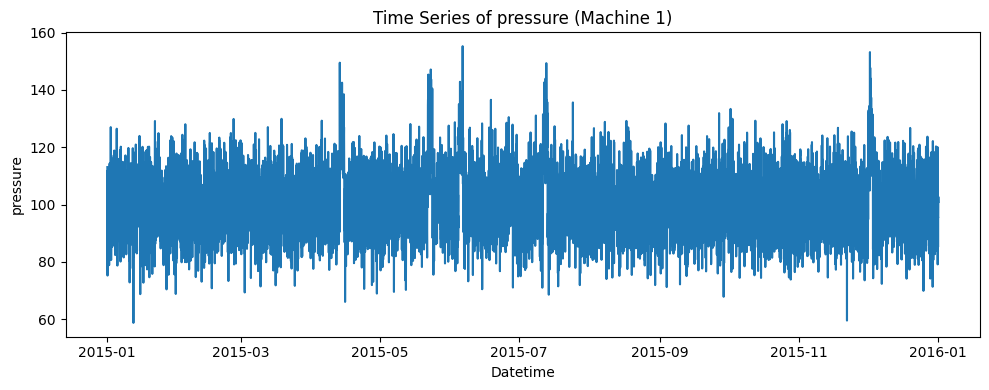

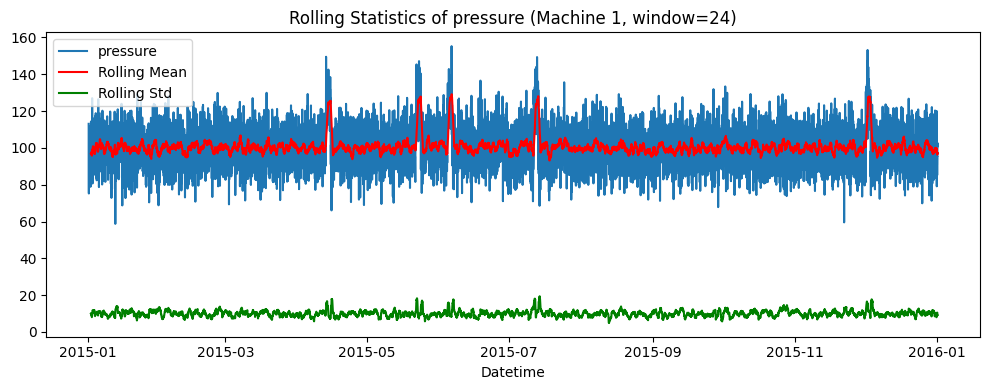

ADF Test for pressure:
  Test Statistic: -13.2491
  p-value: 0.0000
----------------------------------------


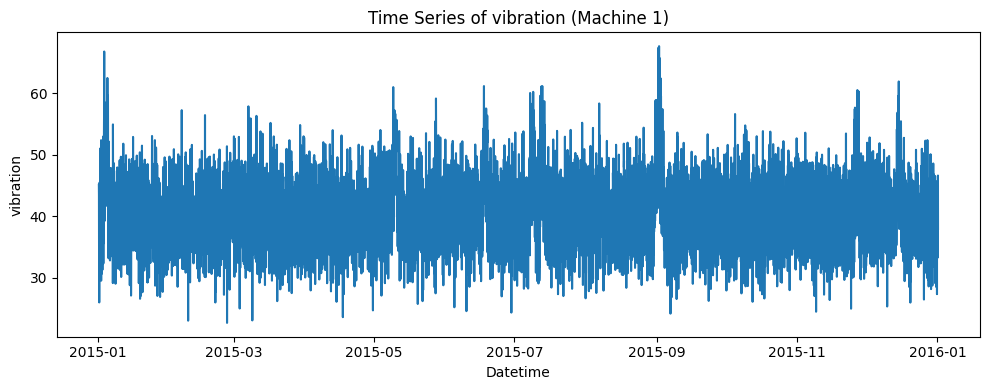

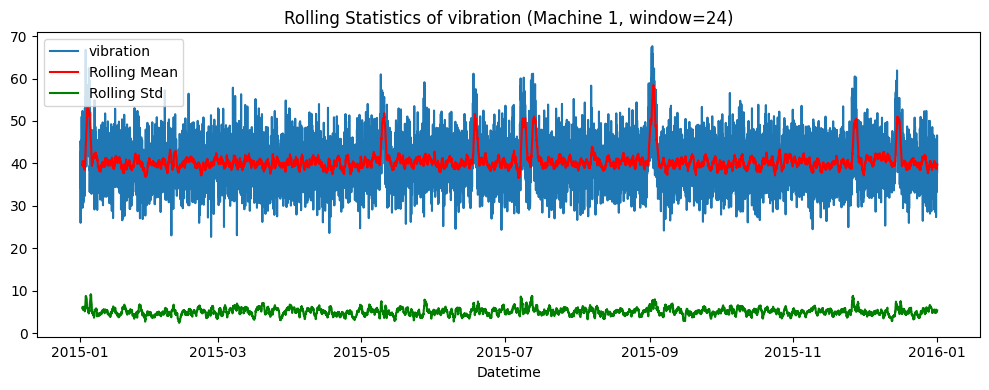

ADF Test for vibration:
  Test Statistic: -12.0948
  p-value: 0.0000
----------------------------------------


In [9]:
machine_of_interest = 1
analyze_time_series_for_machine(
    df, machine_of_interest, sensor_cols, rolling_window=24
)

The Augmented Dickey-Fuller test results suggest that both the “volt” and “pressure” readings from machine 1 are stationary. The test statistics are strongly negative, and the p-values are basically zero, so we can confidently reject the null hypothesis of a unit root. That means **we don’t need to apply differencing or other transformations to deal with non-stationarity** in these sensor signals.

## Seasonality analysis

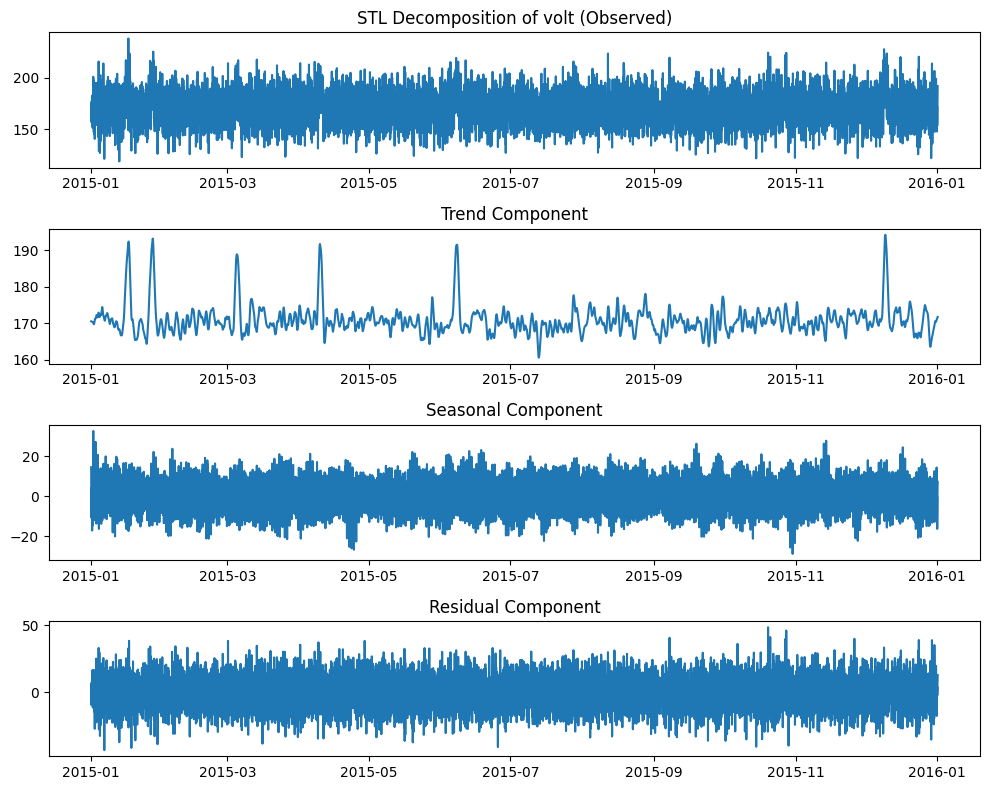

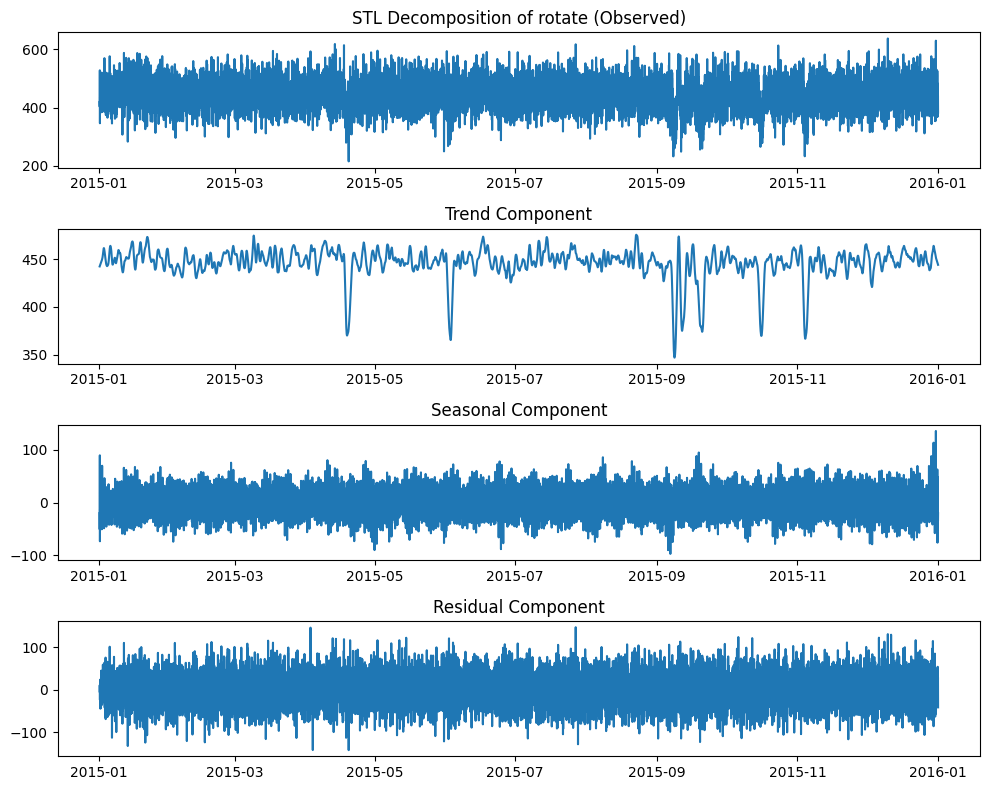

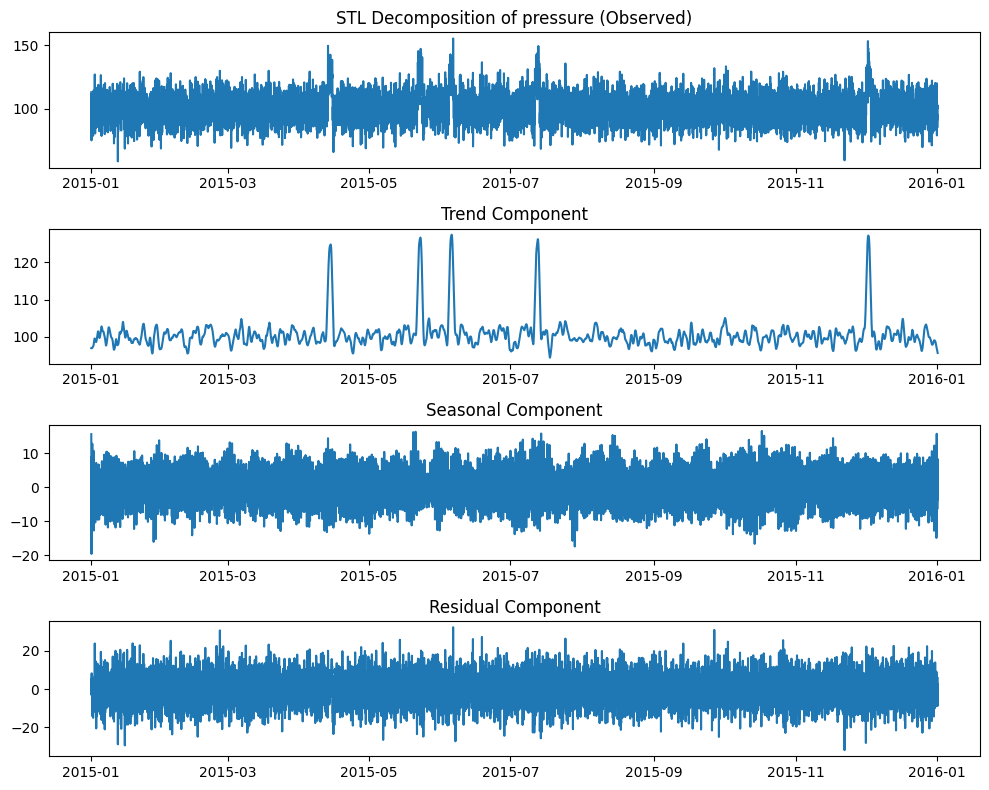

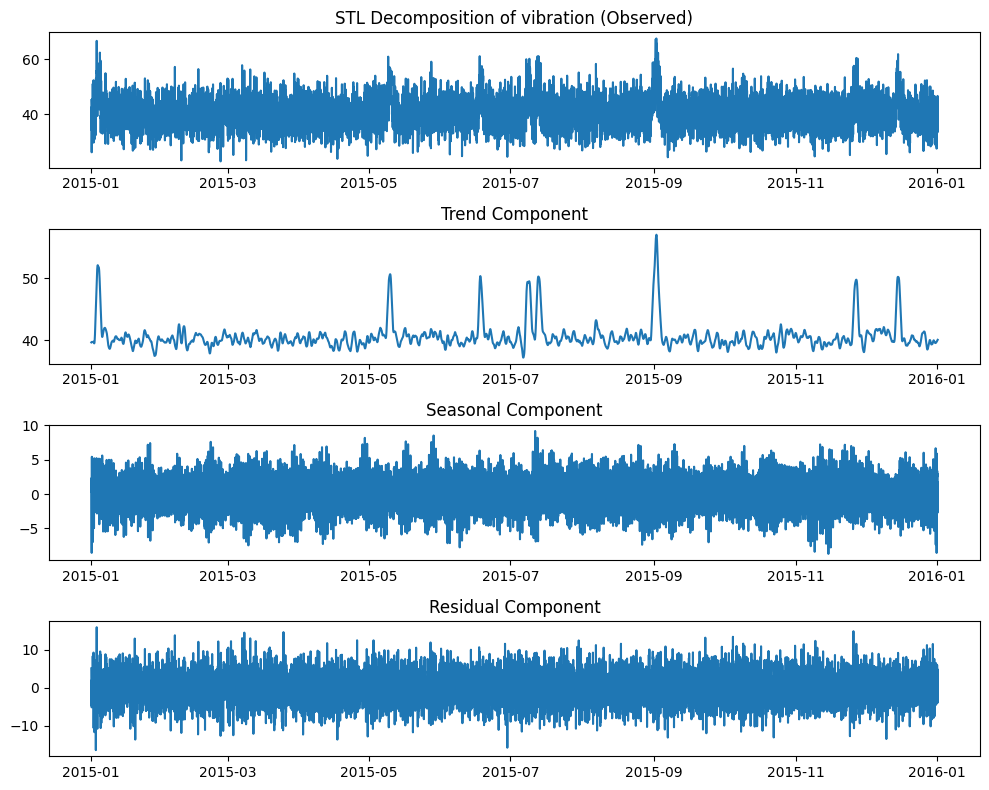

In [10]:
for sensor in sensor_cols:
   plot_stl_decomposition(df, machine_of_interest, sensor, period=24)

Looking at the STL decomposition, the “volt,” “vibration,” and “pressure” signals all show a fairly stable overall trend, with some repeating ups and downs in the seasonal component—though the seasonality isn’t particularly strong. The seasonal patterns shift slightly over time but generally stay within a ±20 range, suggesting a regular yearly cycle. The residuals still show noticeable fluctuations and occasional spikes, which likely reflect short-term events or anomalies that aren’t captured by the trend or seasonality. Overall, these signals exhibit moderate seasonality, gently varying trends, and a fair amount of short-term noise.


Correlation between 'trend_spike' and 'time_to_failure': -0.0159
T-test between TTF when spike vs. no spike: t-stat=-1.3857, p-value=0.1668

Mean TTF by spike indicator:
 trend_spike
0    705.213497
1    668.672956
Name: time_to_failure, dtype: float64


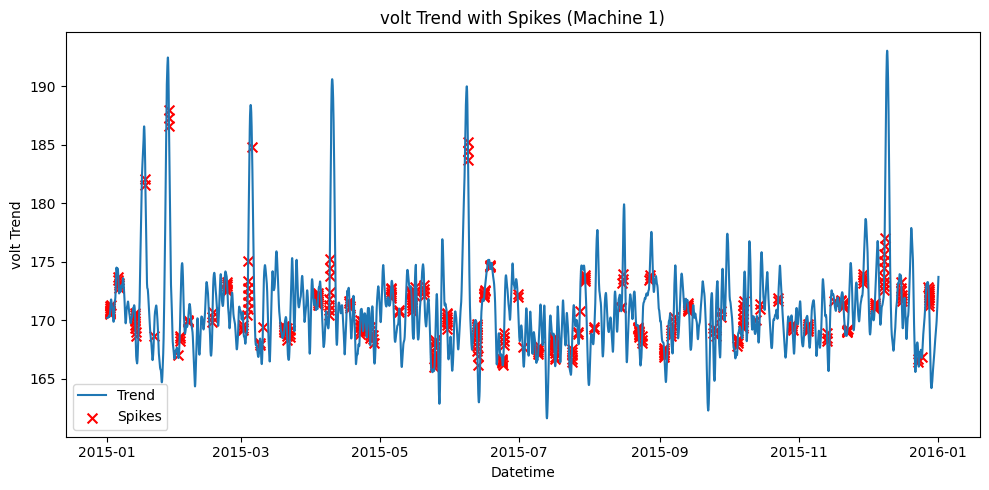

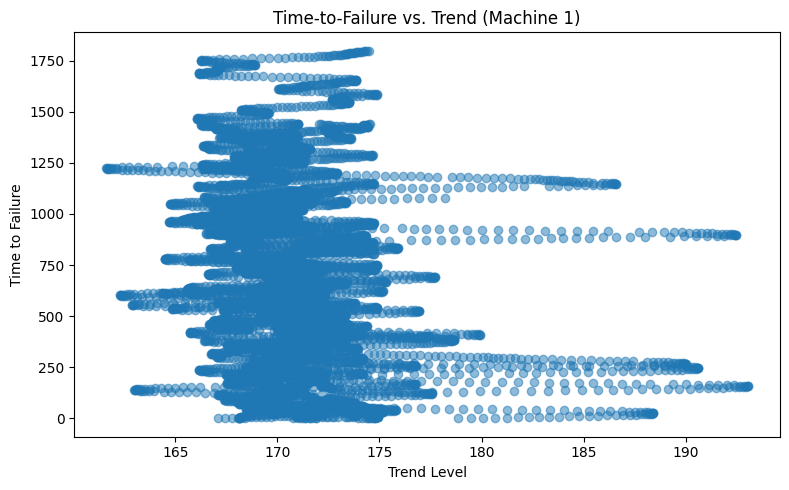


Correlation between 'trend_spike' and 'time_to_failure': 0.0077
T-test between TTF when spike vs. no spike: t-stat=0.6750, p-value=0.5002

Mean TTF by spike indicator:
 trend_spike
0    703.187662
1    721.651724
Name: time_to_failure, dtype: float64


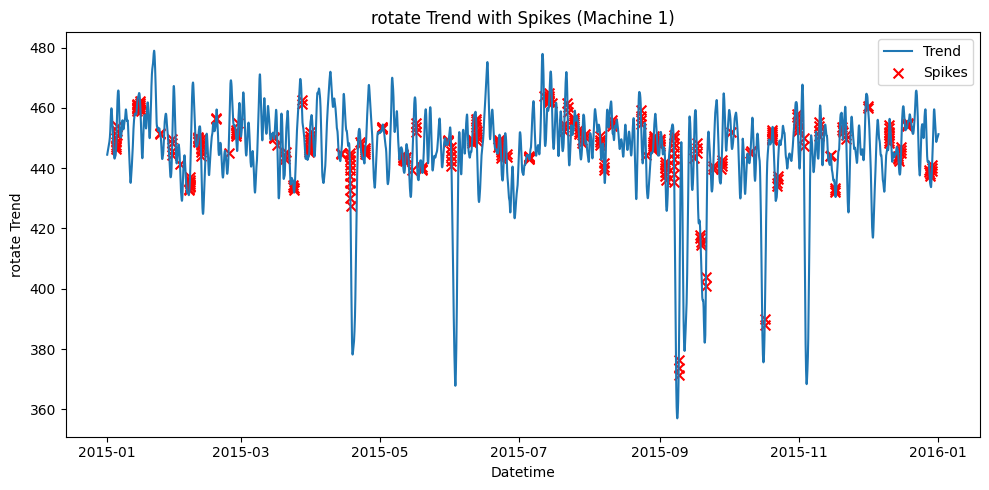

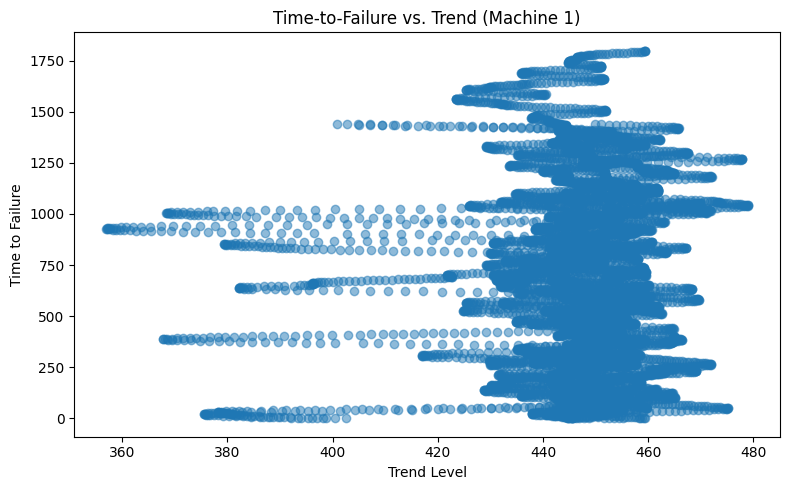


Correlation between 'trend_spike' and 'time_to_failure': 0.0017
T-test between TTF when spike vs. no spike: t-stat=0.1531, p-value=0.8784

Mean TTF by spike indicator:
 trend_spike
0    703.664921
1    707.430556
Name: time_to_failure, dtype: float64


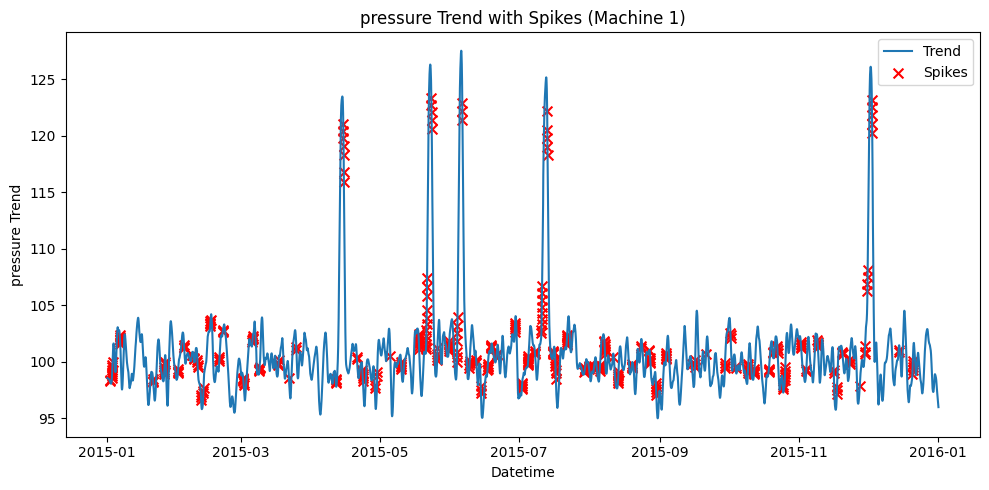

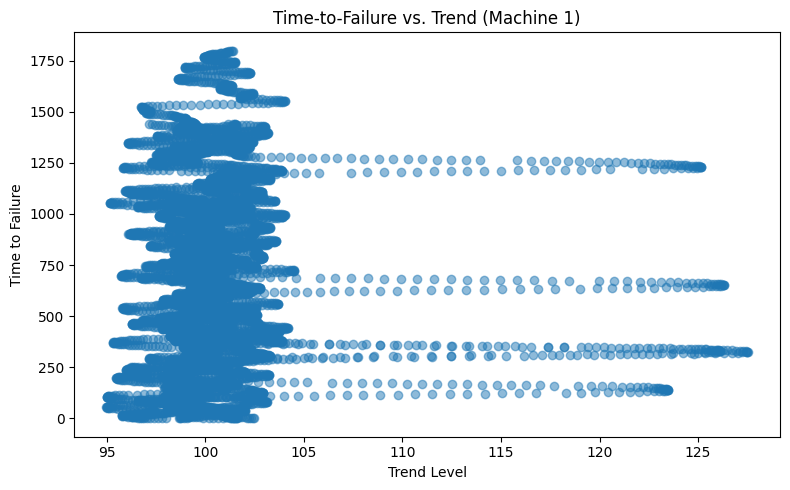


Correlation between 'trend_spike' and 'time_to_failure': -0.0305
T-test between TTF when spike vs. no spike: t-stat=-2.8512, p-value=0.0046

Mean TTF by spike indicator:
 trend_spike
0    706.732658
1    642.317460
Name: time_to_failure, dtype: float64


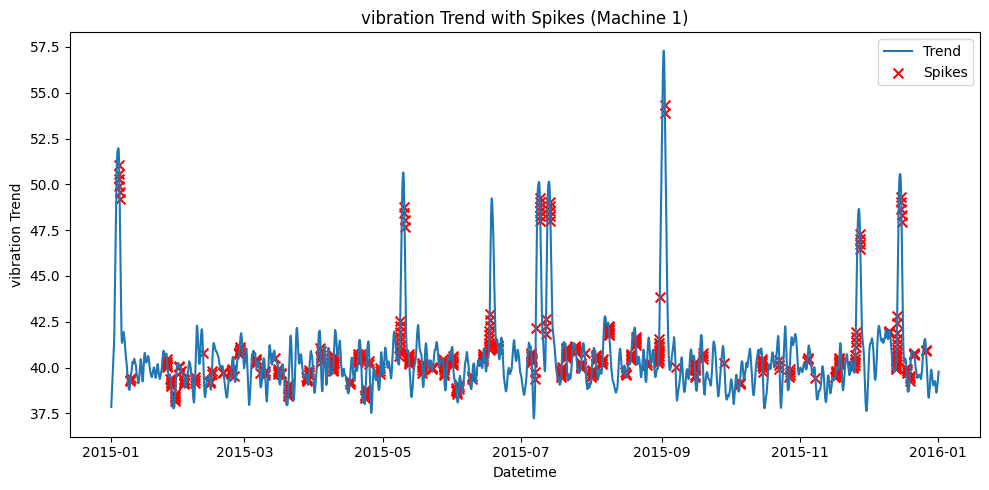

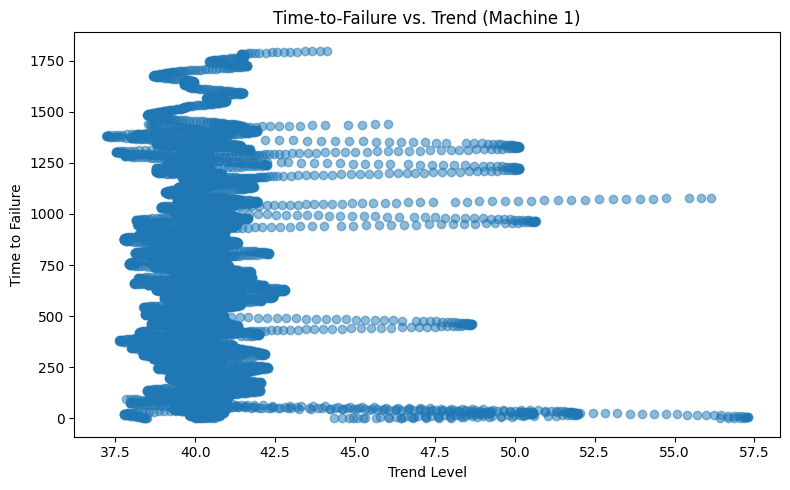

In [11]:
for sensor in sensor_cols:
    analyze_trend_spikes(
        df, machine_of_interest, sensor,
    )

Across the machine, the relationship between trend spikes definition (z-score of 2.5) in sensor readings and the remaining time to failure was analyzed to evaluate whether such spikes could serve as early indicators of breakdown. In most cases, the **correlation between spike presence and time to failure is extremely weak**, hovering around zero (e.g., 0.0077 and 0.0017), suggesting that trend spikes do not consistently predict how close a machine is to failing. The corresponding **t-tests reinforce this**, with high p-values (0.5002 and 0.8784), meaning we cannot reject the null hypothesis—there's no significant difference in TTF whether a spike occurs or not. The average TTF is also nearly the same in both spike and no-spike conditions in these cases, differing by fewer than 20 time units.

However, **in the presion trend, the correlation was slightly more negative (-0.0305)** and the **t-test showed a statistically significant result (t = -2.85, p = 0.0046)**. In this case, the average time to failure during a spike was noticeably shorter (642 vs. 707), suggesting that **for this particular machine or condition, spikes may precede failure more reliably**. Even so, the correlation remains weak, indicating that while there might be a statistically detectable difference, it's not a strong predictive signal on its own.

In summary, **trend spikes alone are not reliable predictors of time to failure across machine for this spike definition**, but it appears to exist a relationship between the bigger spikes and time of failure. It will be revisited the spike definition and the z-score used. A machine learning model could learn them and find them useful in combination with other features.

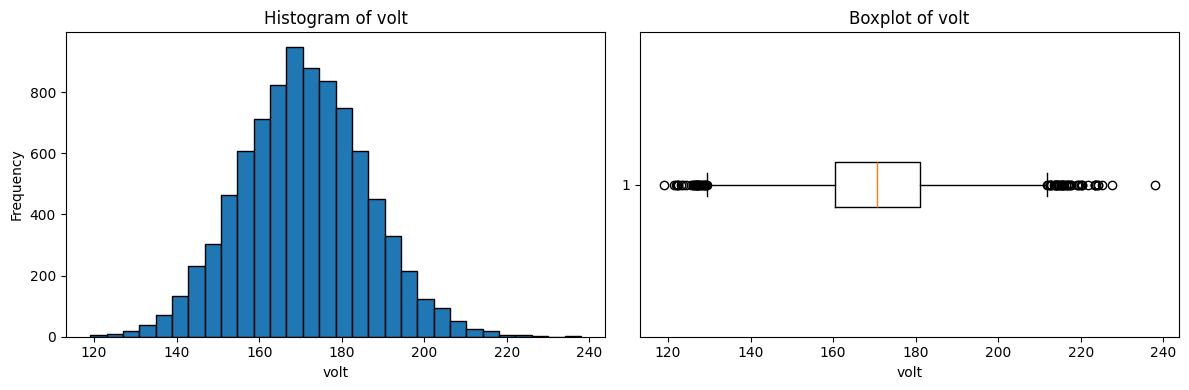

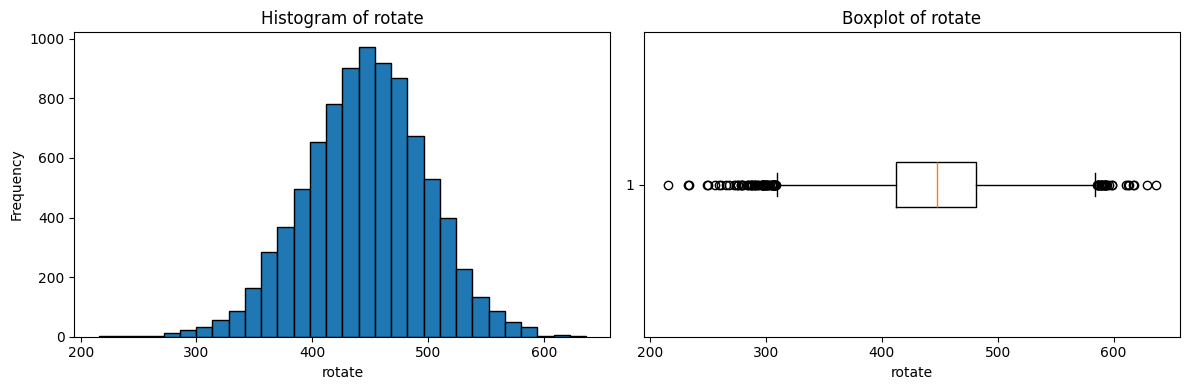

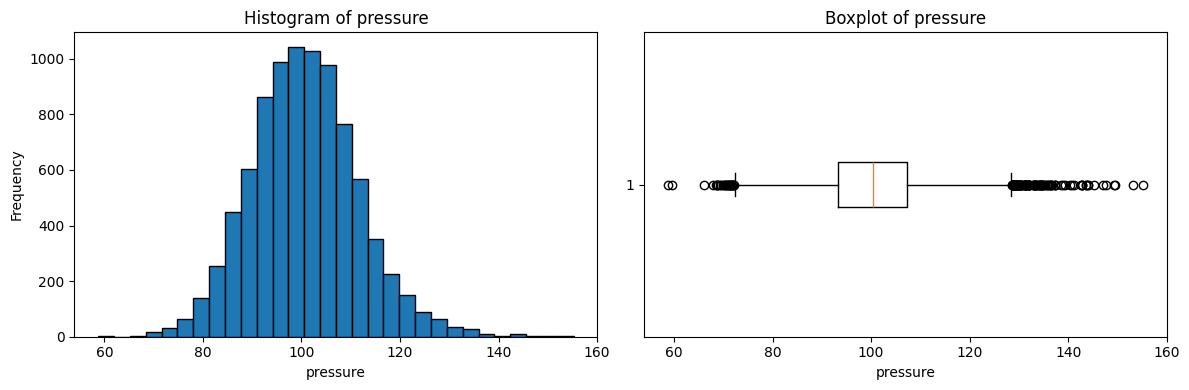

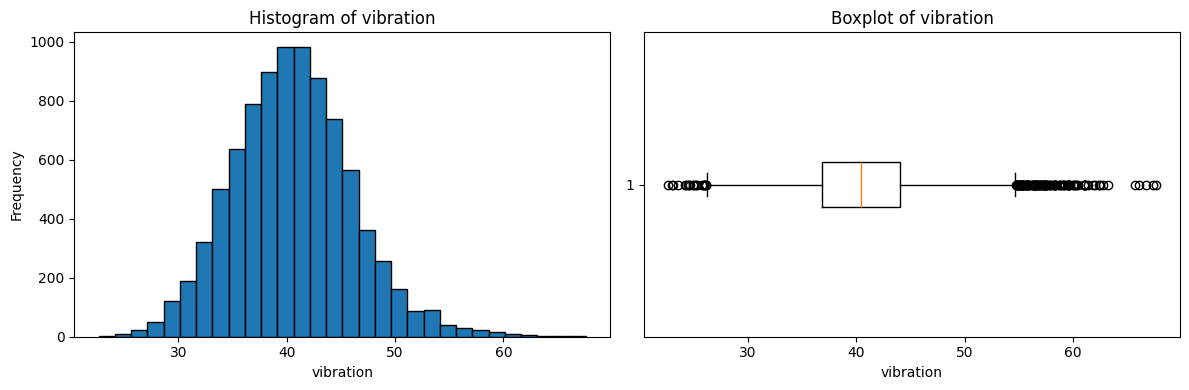

In [12]:
plot_sensor_distributions(df, machine_of_interest, sensor_cols)

The histogram and boxplot of the sensor data indicate that the variable is approximately normally distributed, with a symmetric bell-shaped curve centered around the mean. Although there are some outliers on both tails—visible in the boxplot—most of the data points are tightly clustered around the center, and the distribution does not appear to be heavily skewed. This pattern is consistent with many of the other sensor variables in the dataset, which also show similar normal-like distributions. Given this, applying a standard scaler (which standardizes features by removing the mean and scaling to unit variance) is appropriate. Standard scaling assumes the data is roughly Gaussian for optimal results, and in this case, the assumption holds reasonably well.

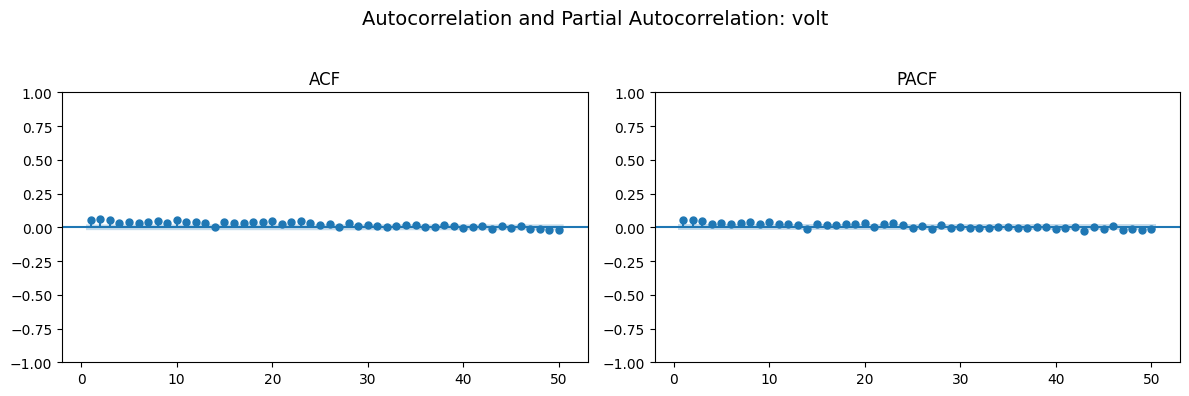

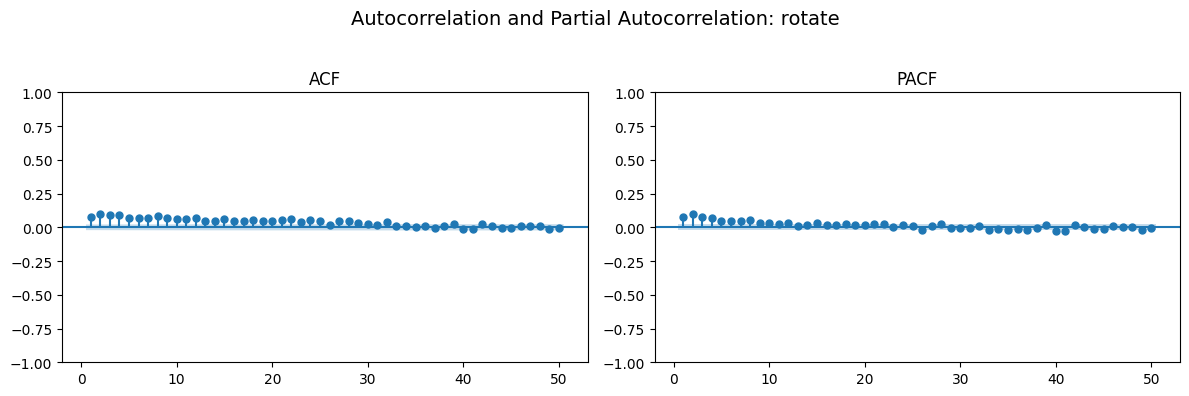

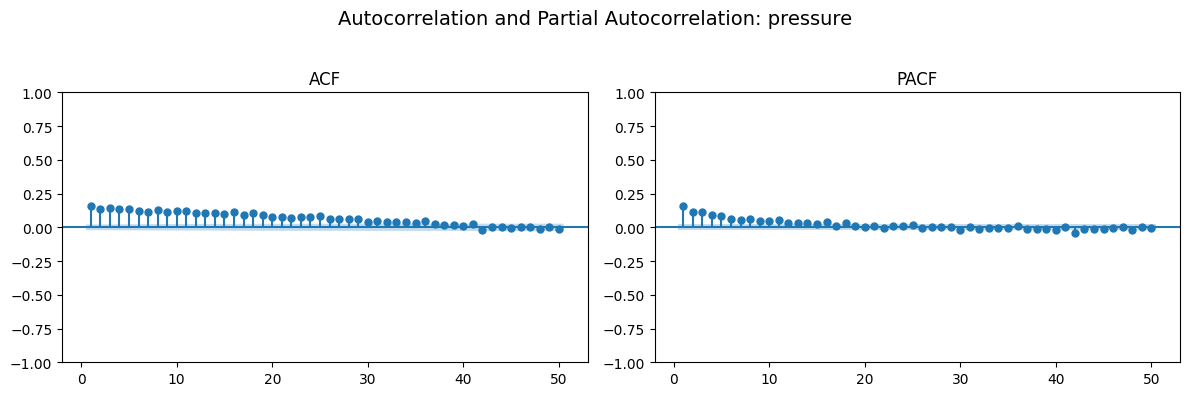

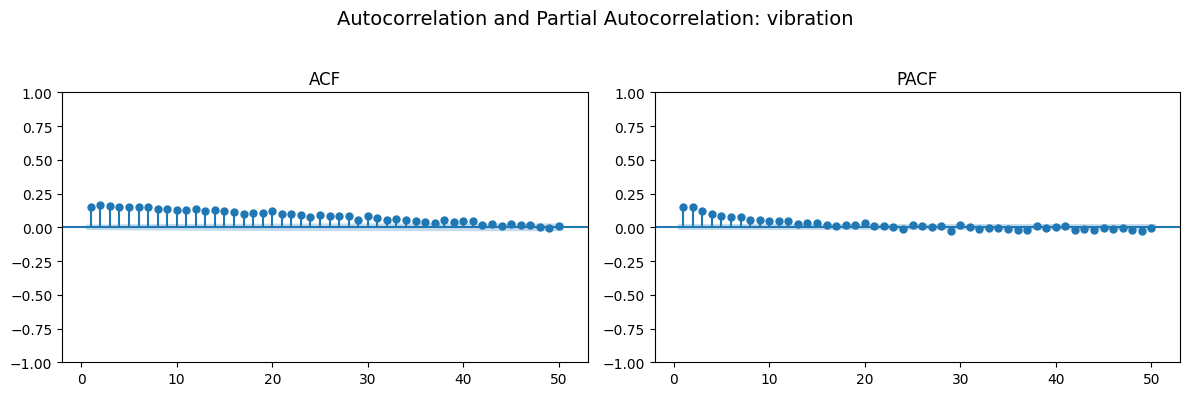

In [13]:
plot_acf_and_pacf(df, machine_of_interest, sensor_cols, lags=50)

The autocorrelation (ACF) and partial autocorrelation (PACF) plots for the sensor readings (volt, rotation, pressure, and vibration) show very low autocorrelation values beyond the initial points, quickly dropping toward zero. This indicates that the sensor data points are nearly independent across time, with no strong temporal dependencies or repeating patterns over short intervals. This behavior is more apparent in rotation and volt. Those sensor measurements reflect random fluctuations or noise rather than systematic or seasonal patterns. However, it’s worth noting that slight but persistent positive correlations at lower lags in vibration and pressure at lags up to 35. So a sliding window for an nn model could be between 10 and 35

Time to Failure Summary After Maintenance:
                 count        mean  median         std
is_fri_weekend                                       
False              14  488.571429   540.0  389.454394
True                9  560.000000   360.0  543.323108 

t-statistic: 0.34194787074842514 | p-value: 0.7377462182411917


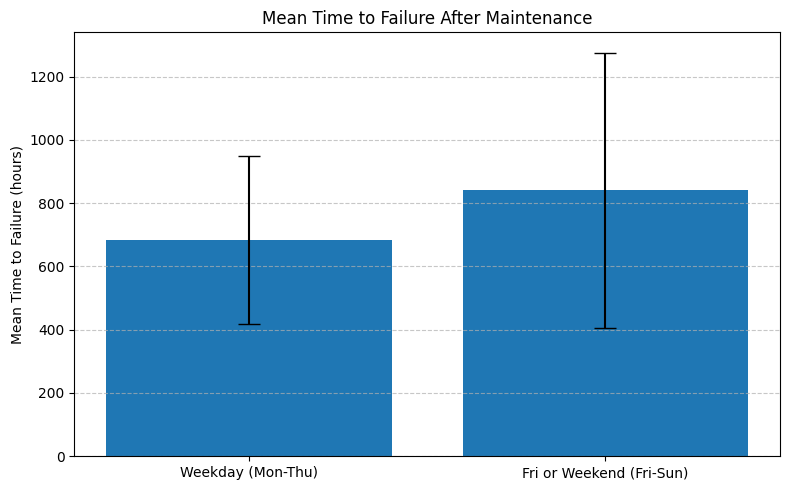

In [14]:
analyze_weekend_maintenance(df, machine_of_interest)

maint_comp1 Data Summary:
                count   mean         std
is_fri_weekend                          
False               4  450.0  540.000000
True                5  432.0  469.382573

maint_comp2 Data Summary:
                count   mean         std
is_fri_weekend                          
False               5  648.0  394.360241
True                3  840.0  749.399760

maint_comp3 Data Summary:
                count   mean         std
is_fri_weekend                          
False               6  660.0  353.949149
True                1  360.0         NaN

maint_comp4 Data Summary:
                count   mean         std
is_fri_weekend                          
False               4  180.0  360.000000
True                4  360.0  509.116882



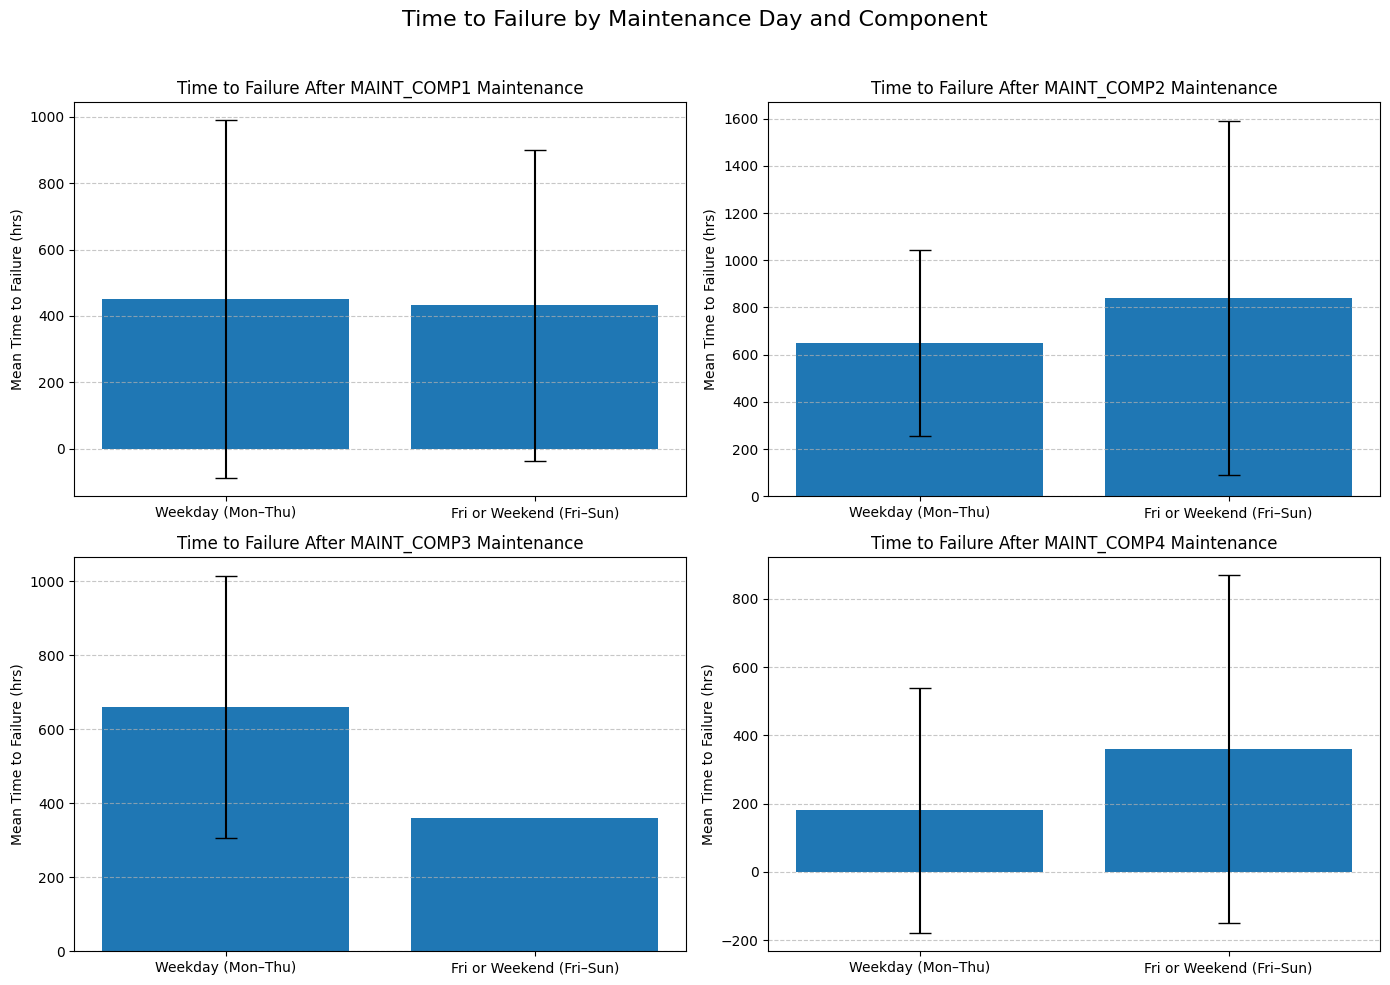

In [15]:
analyze_maintenance_by_component(df, machine_of_interest)

While Components 2 and 4 hint that maintenance done on Fridays or weekends might be associated with longer time-to-failure, the high variability and small sample sizes—especially in Components 3 and 4—mean these findings should be interpreted cautiously. A larger dataset or statistical testing would be needed to confirm whether these are genuine patterns or simply the result of noise in a limited sample.

In [16]:
analyze_time_features(df, machine_of_interest)

Correlation of hour_sin with time_to_failure: -0.0024
Correlation of hour_cos with time_to_failure: -0.0122
Mean of time_since_last_failure_flag (< 10000): 688.67
Max of time_since_last_failure_flag (< 10000): 1799.00

Hourly Statistics:
             mean  median         std  count
hour                                       
0     695.124654   666.0  440.154901    361
1     696.124654   667.0  440.154901    361
2     697.124654   668.0  440.154901    361
3     698.124654   669.0  440.154901    361
4     699.124654   670.0  440.154901    361
5     700.124654   671.0  440.154901    361
6     678.401099   648.0  439.501043    364
7     678.124654   649.0  440.154901    361
8     679.124654   650.0  440.154901    361
9     680.124654   651.0  440.154901    361
10    681.124654   652.0  440.154901    361
11    682.124654   653.0  440.154901    361
12    683.124654   654.0  440.154901    361
13    684.124654   655.0  440.154901    361
14    685.124654   656.0  440.154901    361
15    686.124